In [9]:
import h5py
import os

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from tqdm import tqdm

import sys
sys.path.insert(0, "../scripts/")
from ns_2d import NSTwo

In [10]:
checkpoint_file = "../outputs/ns-feat-2d-3-theta-0.50.h5"
ns = NSTwo("../mesh/featflow-2d-3-benchmark.xdmf",
           dict(dt=1/1600, theta=0.6, setup="feat"))

checkpoint = fe.HDF5File(fe.MPI.comm_world, checkpoint_file, "r")
nt_stored = checkpoint.attributes("/")["nt"]
nt_plot = [i for i in range(nt_stored) if i % 10 == 0]

# check how much is actually stored in the file
checkpoint_h5 = h5py.File(checkpoint_file, "r")
# du_keys = list(checkpoint_h5["du"].keys())
# nt_stored = sum(["vector" in key for key in du_keys])
print(checkpoint_h5["/du/vector_100"])

<HDF5 dataset "vector_100": shape (34317,), type "<f8">


In [11]:
# midpoint
t = np.zeros((len(nt_plot), ))
u_midpoint = np.zeros((len(nt_plot), ))
delta_p = np.zeros((len(nt_plot), ))

for i, i_vec in enumerate(nt_plot):
    # load in value
    vec_name = f"/du/vector_{i_vec}"
    checkpoint.read(ns.du, vec_name)

    # compute average u value
    vel, p = ns.du.split()
    u, v = vel.split()

    # load in attributes
    t[i] = checkpoint.attributes(vec_name)["timestamp"]
    delta_p[i] = p(0.15, 0.2) - p(0.25, 0.2)
    u_midpoint[i] = u(0.4, 0.2)
    
checkpoint.close()

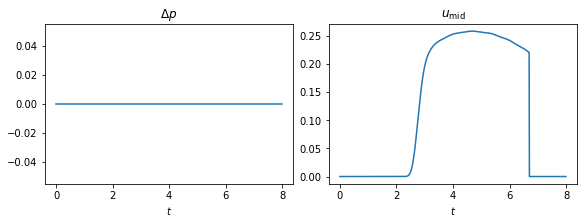

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3),
                        constrained_layout=True)
axs[0].plot(t, delta_p)
axs[0].set_title(r"$\Delta p$")
axs[1].plot(t, u_midpoint)
axs[1].set_title(r"$u_{\mathrm{mid}}$")

for ax in axs:
    ax.set_xlabel(r"$t$")
plt.show()

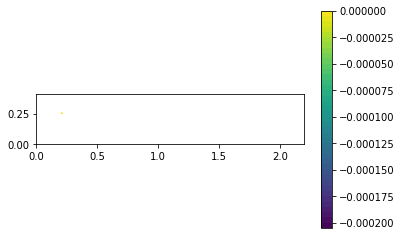

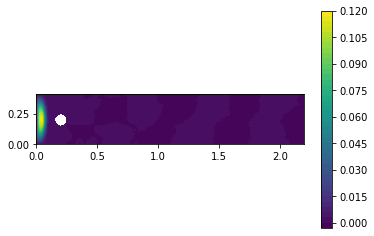

In [13]:
im = fe.plot(p)
plt.colorbar(im)
plt.show()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

In [6]:
import pandas as pd

p_ref_left = pd.read_csv(
    "../data/pressure_q2_cn_lv1-6_dt4/pointvalues_lv4",
    sep=None, header=0, engine='python', usecols=list(range(1, 7)))

print(p_ref_left)

p_ref_right = pd.read_csv(
    "../data/pressure_q2_cn_lv1-6_dt4/pointvalues_lv4",
    sep=None, header=0, engine='python', usecols=list(range(7, 12)))

           time     x         y  type  deriv     value
0      0.000000  0.15  0.199999     3      0  0.000000
1      0.000313  0.15  0.199999     3      0  0.410738
2      0.000937  0.15  0.199999     3      0  0.411794
3      0.001563  0.15  0.199999     3      0  0.412566
4      0.002188  0.15  0.199999     3      0  0.413256
...         ...   ...       ...   ...    ...       ...
12796  7.997187  0.15  0.199999     3      0 -0.438204
12797  7.997813  0.15  0.199999     3      0 -0.438325
12798  7.998437  0.15  0.199999     3      0 -0.438446
12799  7.999062  0.15  0.199999     3      0 -0.438568
12800  7.999688  0.15  0.199999     3      0 -0.438689

[12801 rows x 6 columns]


ValueError: operands could not be broadcast together with shapes (800,) (1280,) 

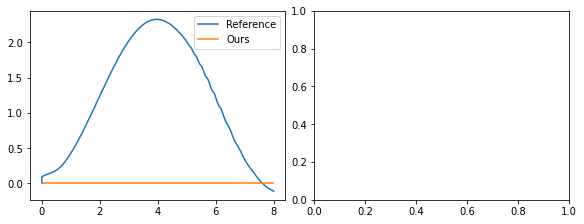

In [8]:
delta_p_ref = p_ref_left["value"] - p_ref_right["value.1"]

fig, axs = plt.subplots(1, 2, figsize=(8, 3),
                        constrained_layout=True)

axs[0].plot(p_ref_left.time,
         p_ref_left["value"] - p_ref_right["value.1"],
         label="Reference")
axs[0].plot(t, delta_p, label="Ours")
axs[0].legend()

axs[1].plot(t[1:], np.abs(delta_p - delta_p_ref[1::10])[1:])
axs[1].set_title("|Ref. - Ours|")
plt.show()

In [ ]:
ns.du.copy()